In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm 
import matplotlib.cm as cm
import pandas as pd 

In [56]:
%run 'params_paper.ipynb'

## Functies

#### Environment

In [57]:
def update_n(n, z, e1):
    return n + e1 * (z - n)

#### Heuristics and updating

In [58]:
def predict_zl(z_evolution, heuristic, b1, b2, b3):
    t = len(z_evolution)
    if heuristic == 0: # adaptive expectation on zl (essentially exponential weights on all memories)
        expec = np.sum([z_evolution[i] * b1 * (1-b1) ** (t-i-1) for i in range(t)])
    elif heuristic == 1: # trend-chasing expectation on zl
        if t > 1:
            expec = z_evolution[-1] + b2 * (z_evolution[-1] - z_evolution[-2]) 
        else: 
            expec = z_evolution[-1]  # no trend to extrapolate so just previous observation
    elif heuristic == 2: # contrarian (trend-chasing) expectation on zl
        if t > 1:
            expec = z_evolution[-1] + b3 * (z_evolution[-1] - z_evolution[-2]) 
        else: 
            expec = z_evolution[-1]  # no trend to extrapolate so just previous observation
    else: # anchoring and adjustment expectation on zl
        if t > 1:
            expec = 0.5 * (np.mean(z_evolution) + z_evolution[-1]) + (z_evolution[-1] - z_evolution[-2]) 
        else: 
            expec = z_evolution[-1] # no trend to extrapolate so just anchor point
    return np.clip(expec, 0, 1)

def update_heuristic(old_utilities, previous_z, previous_expectations, current_heuristic, h_upd_chance, eta, choice_intensity):
    new_utilities = np.array([-(previous_z - previous_expectations[i]) ** 2 + eta * old_utilities[i] for i in range(len(previous_expectations))])
    draw1 = np.random.uniform()
    if draw1 < h_upd_chance: # only update h_upd_chance percent of the time
        sum = np.sum(np.exp(choice_intensity * new_utilities))
        draw2 = np.random.uniform()
        count = np.exp(choice_intensity * new_utilities[0])
        id = 0
        while draw2 >= count/sum:
            id += 1
            count += np.exp(choice_intensity * new_utilities[id])
        return id, new_utilities
    else:
        return current_heuristic, new_utilities

#### Agent decision-making

In [59]:
def base_sigmoid(pd, degree, sigma):
    beta = np.sqrt(degree) / sigma 
    return 1 / (1 + np.exp(-beta * pd))

def action(n, z_evolution, d0, a1l, a1h, a2l, a2h, a3l, a3h, P, b1, b2, b3, heuristic, degree, sigma):
    ze_t = predict_zl(z_evolution, heuristic, b1, b2, b3)
    pd = d0 + (a1h-a1l) * (ze_t * (P-1)/P) + (a2h - a2l) * n + (a3h - a3l) * n * ze_t * (P-1)/P - a1l/P - a3l * n / P 
    #pd = d0 + (a1h-a1l) * ze_t + (a2h - a2l) * n + (a3h - a3l) * n * ze_t - a1l/P - a3l * n / P # de P factor zit al in observation functions

    random_draw = np.random.uniform()
    cutoff = base_sigmoid(pd, degree, sigma)
    if random_draw < cutoff:
        return 1, ze_t, pd
    else:
        return 0, ze_t, pd

#### Network functions

In [60]:
def gen_net(P, ne):
    if type(ne) == np.int64 or type(ne) == int:
        network = nx.barabasi_albert_graph(P,int(ne))
    else:
        network = nx.gnp_random_graph(P, ne)
    A = nx.to_numpy_array(network) + np.eye(P)
    return A, np.sum(A, axis=0) 

def construct_perceived_weights(A, impact):
    P = A.shape[0]
    SA = np.sum(A, axis=0)
    SA_power = SA ** impact
    SA_imp_matrix = np.tile(SA_power, (P, 1))
    
    if impact == 0:
        perceived_weights = A / np.tile(np.sum(A, axis=1), (P, 1)).T 
    else:
        perceived_weights = A * SA_imp_matrix / (np.sum((SA * A) ** impact, axis=1)[:, np.newaxis])
    
    return perceived_weights

#### Other functions

In [61]:
def mean_conf(results, x):
    mean = np.mean(results, axis=0)
    conf = 1.96 * np.std(results, axis=0) / np.sqrt(x)
    return mean, conf 

def br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, p):
    if a3l == a3h:
        num = a1l / p - d0
        den = (a1h - a1l) * (p - 1) / p + a2h - a2l - a3l/p 
        zlr = np.array([num/den, num/den])
    else:
        a = d0-a1l/p
        b = (a1h-a1l) * (p-1) + a2h-a2l - a3l/p
        c = (a3h-a3l) * (p-1)/p
        D = b ** 2 - 4 * a * c
        zlr = np.array([(-b + np.sqrt(D)) / (2*a), (-b - np.sqrt(D)) / (2*a)])
    np.put(zlr, np.append(np.where(zlr>1), np.where(zlr<0)),np.nan)
    return zlr

def calc_moment(degrees, P, n_bins=20, moment=3):
    weights, bin_edges = np.histogram(degrees, bins=n_bins, range=(0,P))
    values = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in range(n_bins)])
    ave = np.average(values, weights=weights)
    var = np.sum(np.array([weights[i]*(values[i]-ave)**moment for i in range(n_bins)]))
    return var ** (1/moment) / P

#### Model

In [62]:
def model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity):
    z = 1 # with new environmental weights, initial conditions for z are a bit tricky NEW
    A, degrees = gen_net(P, ne) # form the network
    skew = calc_moment(degrees, P)
    n_evolution = np.ones((T+1)) * n 
    z_evolution = np.ones((T+1)) * z       
    actions = np.random.permutation(np.append(np.zeros(int(z*P)), np.ones(P-int(z*P)))) 
    z_predictions = np.empty(T)
    observed_z = np.empty(T)
    pd = np.empty(T)
    heuristic = np.random.randint(low=0, high=4, size=P) # period 1 and 2 everyone uses a random heuristic; high 4 because 4 heuristics
    heuristic_fraction = np.zeros((T+1, 4))
    heuristic_fraction[0,:] = np.array([np.count_nonzero(heuristic == h)/P for h in range(4)])
    utilities = np.zeros((P, 4)) # four heuristics 
    memory = np.zeros((P,P)) * np.nan 
    indices = np.where(A == 1)
    memory[indices] = actions[indices[1]]
    perceived_z = {i: np.array([]) for i in range(P)}
    perceived_n = np.ones(P) * n
    acting_p = np.empty(T)
    weights = degrees ** impact / np.sum(degrees ** impact) # these are used to update the resource state
    perceived_z_weights = construct_perceived_weights(A - np.eye(P), impact) # these have no self link and are used for taking into account environmental impact for forming expectations
    perceived_n_weights = construct_perceived_weights(A, impact) # these have a self link and are used for taking into account environmental impact for resource state perception updates

    for i in range(T):
        # choose a random player that acts
        id = np.random.randint(0,P)
        acting_p[i] = id
        old_heuristic = heuristic[id]
        old_action = actions[id]
        observation = memory[id].copy()
        observation[id] = np.nan # since want to predict the other users' behaviour, not your own
        perceived_z[id] = np.append(perceived_z[id], 1-np.nansum(observation * perceived_z_weights[id,:])) # take a snapshot of behaviour each time you act
        observed_z[i] = perceived_z[id][-1]

        # choose heuristic
        if len(perceived_z[id]) > 1: # can't update heuristics in first two periods as requires two previous expectations
            first_order_expectations = np.array([predict_zl(perceived_z[id][:-1], h, b1, b2, b3) for h in range(4)])
            heuristic[id], utilities[id,:] = update_heuristic(utilities[id,:], perceived_z[id][-1], first_order_expectations, heuristic[id], 
                                                    h_upd_chance, eta, choice_intensity)

        # choose which action maximizes discounted expected payoff
        actions[id], z_predictions[i], pd[i] = action(perceived_n[id], perceived_z[id], d0, a1l, a1h, a2l, a2h, a3l, a3h, P, b1, b2, b3, heuristic[id], degrees[id], sigma)
        
        # update agents' memories and perceived_n
        if A[:, id].any():
            memory[:, id] = np.where(A[:, id], actions[id], memory[:, id])
        perceived_n = update_n(perceived_n, 1-np.nansum(memory * perceived_n_weights, axis=1), e1/P) # each time someone acts, update perception of n using your view of what everyone is doing

        # update z, environment, and heuristic fraction
        diff = actions[id] - old_action
        if diff == 1:
            z_evolution[i+1] = z_evolution[i] - weights[id] 
        elif diff == -1:
            z_evolution[i+1] = z_evolution[i] + weights[id] 
        else:
            z_evolution[i+1] = z_evolution[i]
        n_evolution[i+1] = update_n(n_evolution[i], z_evolution[i+1], e1/P)

        heuristic_fraction[i+1,:] = heuristic_fraction[i,:]
        heuristic_fraction[i+1, old_heuristic] -= 1/P 
        heuristic_fraction[i+1, heuristic[id]] += 1/P 
        
    return n_evolution, z_evolution, z_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew

## Run the model

In [85]:
a1h = 3 * e1
d0 = -0.3
choice_intensity = 100
T = 25000
P = 1000
ne = 250
impact = 0

n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
    = model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)

In [86]:
def plot(periods, series, labels):
    fig = plt.figure(figsize=(20, 5))
    x = np.arange(periods)
    for i in range(np.shape(series)[0]):
        plt.plot(x, series[i,:], label=labels[i])
    plt.grid()
    plt.legend()
    plt.xlabel('Time')

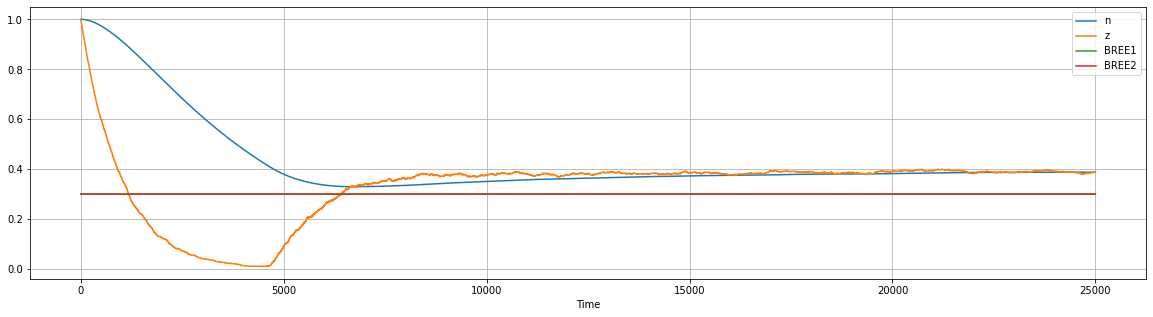

In [87]:
BREE1, BREE2 = br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)
series = np.array([n_evolution, z_evolution, np.ones(T+1)*BREE1, np.ones(T+1)*BREE2])
plot(T+1, series, ['n', 'z', 'BREE1', 'BREE2'])

In [112]:
np.shape(np.where(pd[-5000:]>0))

(1, 3109)

In [113]:
np.shape(np.where(pd[-5000:]<0))

(1, 1891)

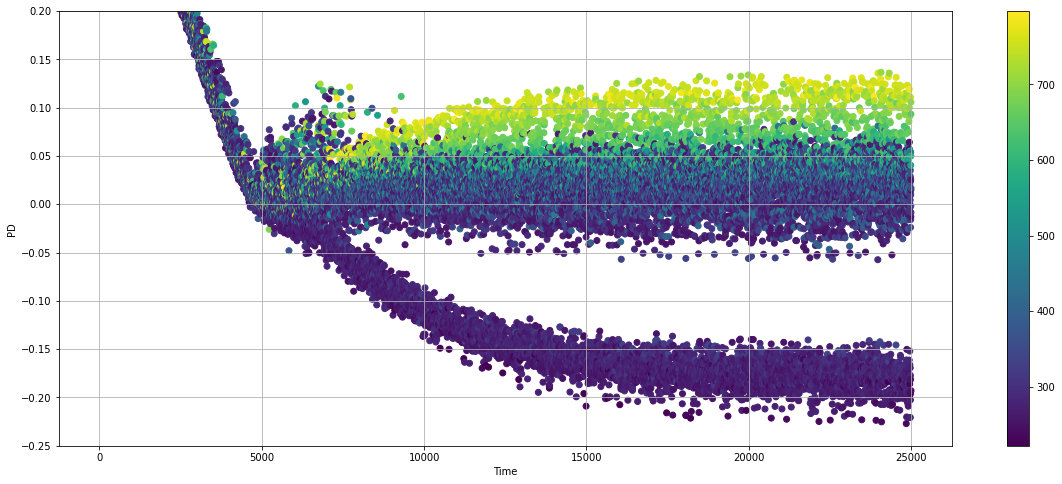

In [110]:
fig = plt.figure(figsize=(20, 8))
plt.scatter(np.arange(T), pd, c=degrees[acting_p.astype(int)])
plt.grid()
plt.ylim(-0.25, 0.2)
plt.xlabel('Time')
plt.ylabel('PD')
plt.colorbar()
plt.show()

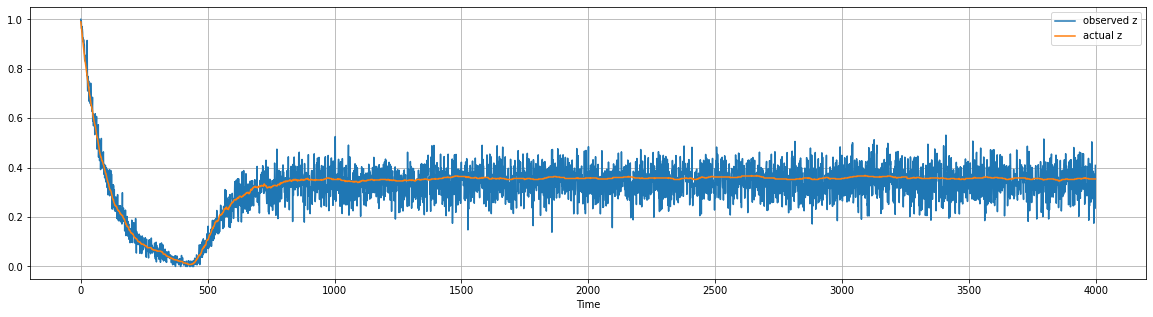

In [147]:
# series = np.array([mean_observed_z, mean_z[1:]])
# plot(T, series, ['observed z', 'actual z'])

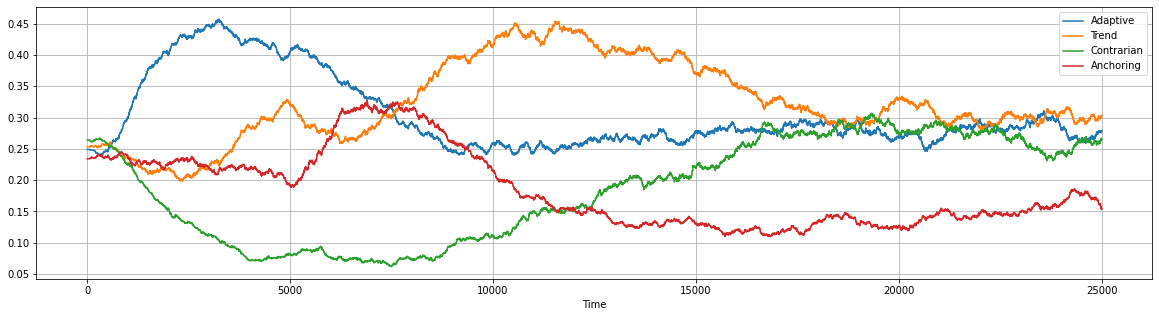

In [74]:
plot(T+1, mean_heuristic.T, ['Adaptive', 'Trend', 'Contrarian', 'Anchoring'])

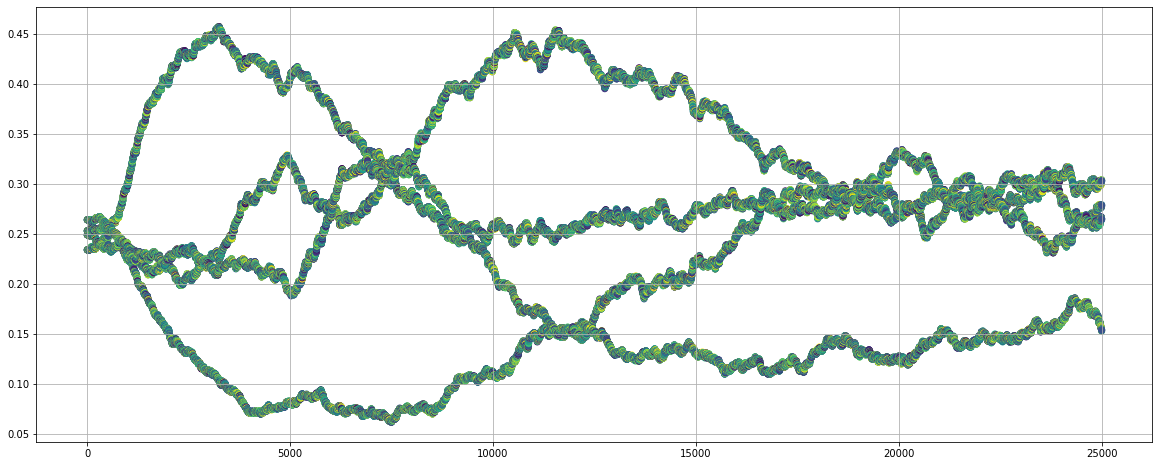

In [95]:
fig = plt.figure(figsize=(20, 8))
cmaps=['Blues', 'Reds', 'Greens', 'Greys']
for i in range(4):
    plt.scatter(np.arange(T), mean_heuristic[1:,i].T, c=mean_acting_p)
#plot(T+1, mean_heuristic.T, ['Adaptive', 'Trend', 'Contrarian', 'Anchoring'])
plt.grid()

- negative feedback (positive mentionen maar geen figuur of in supplement?)
- BA network
- increase population size
- forecast 1 period ahead, dont even talk about it
- is there relationship degree en heuristics (hypothese nee want bij negative feedback zelfde utility)

- plot 1 laten zien wat environmental dynamics verschil is tussen positieve en negatieve feedback (hangt af van markt en social aspect) en hoe dit heuristic keuze beinvloedt
- dan focus op negatieve feedback --> dan plot 2 die ook in presentatie zit --> misschien niet, de x-as is een beetje slecht. checken of met bv gini coefficient kant en zo niet kan bijstabiltiy ook wel zonder de x-as 
hier laten zien dat 1 persoon iedereen misleidt (majority illusion) met PD plot. voor beide steady states 1 plot. wat bepaalt welke van de 2 gebeurt?
- dit heeft bizarre policy consequenties: het is goed als 1 grote speler iets slechts doet. kan ook in echte wereld waar als exxon olie dumpt de rest wil laten zien hoe goed zij zijn. in model heeft exxon alleen geen grote environmental impact maar zelfde als rest. 
- daarom extensie model waarin dat wel kan: zie hieronder. is er een kritiek punt waar het niet meer goed is als de big boy H kiest?

- wat als er correlatie is tussen visibility in network en environmental impact
- ki^P / som(ki^P) * e is environmental impact ---> ki is degree van speler i en P controlled hoeveel impact grootste heeft in feite. als 0 iedereen hetzelfde, als oneinding heeft grootste alle impact

niuwe plannen:
- sigma er weer in (vitor stelde beta van 1 voor)
- how often do you go to upper regime and to lower regime --> flipped naast de veel simulaties plot
- captions bij figuren
- 1000 agents, heb veel runs nodig (begin met minder), experiment met ne

## Plots voor in de paper

In [9]:
T = 40000
P = 1000
ne = 250
impact = 0
runs = 100

##### rolling average van state-degree correlation

In [22]:
window = 1000
results = np.zeros((runs, T))

for i in range(runs):
    acting_degree = degrees_results[i, acting_p_results[i, :].astype(int)]
    action = np.where(pd_results[i,:] >= 0, 1, 0)
    s1 = pd.Series(acting_degree)
    s2 = pd.Series(action)
    results[i,:] = s1.rolling(window).corr(s2)

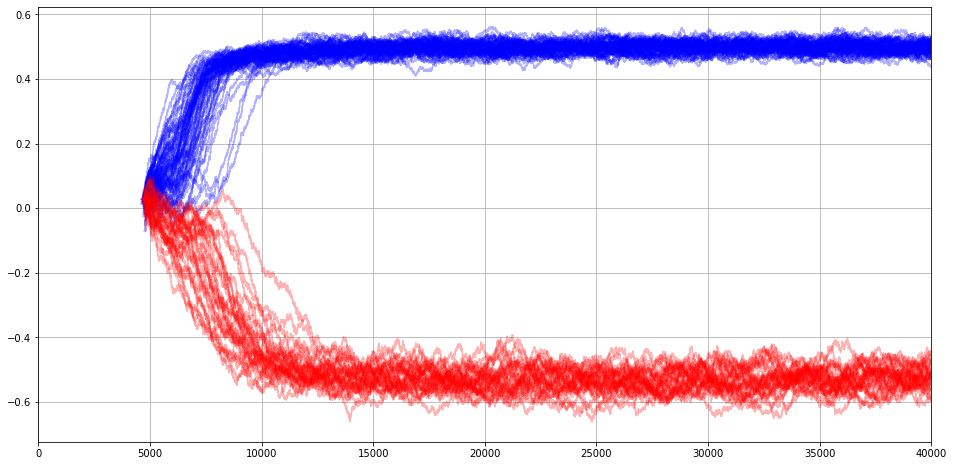

In [27]:
fig = plt.figure(figsize=(16, 8))
for i in np.where(above_int==1)[0]:
    plt.plot(np.arange(T), results[i,:], color='blue', alpha=0.3)
for i in np.where(above_int==0)[0]:
    plt.plot(np.arange(T), results[i,:], color='red', alpha=0.3)
plt.plot([5000, 5000], [np.min(results), np.max(results)])
plt.xlim(0,T)
plt.grid()
plt.show()

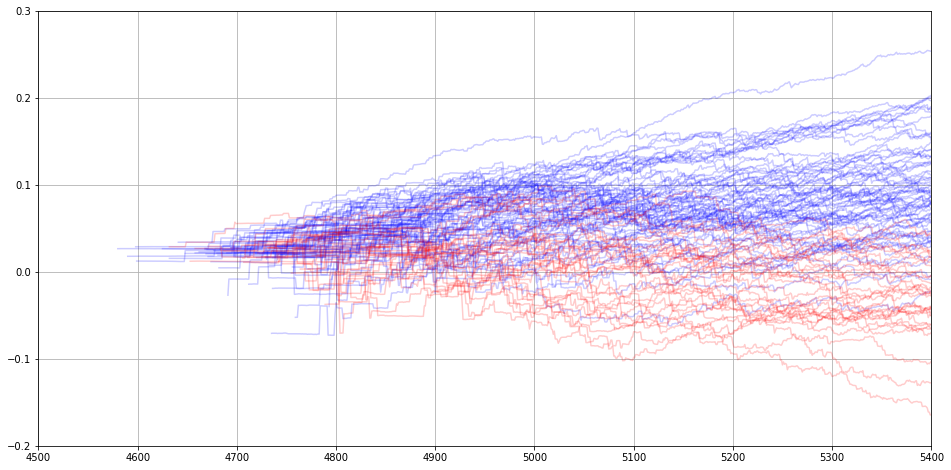

In [47]:
fig = plt.figure(figsize=(16, 8))
for i in np.where(above_int==1)[0]:
    plt.plot(np.arange(T), results[i,:], color='blue', alpha=0.2)
for i in np.where(above_int==0)[0]:
    plt.plot(np.arange(T), results[i,:], color='red', alpha=0.2)
plt.plot([5000, 5000], [np.min(results), np.max(results)])
plt.xlim(4500, 5400)
plt.ylim(-0.2, 0.3)
plt.grid()
plt.show()

The correlation is nan before 5000 because everyone chooses H

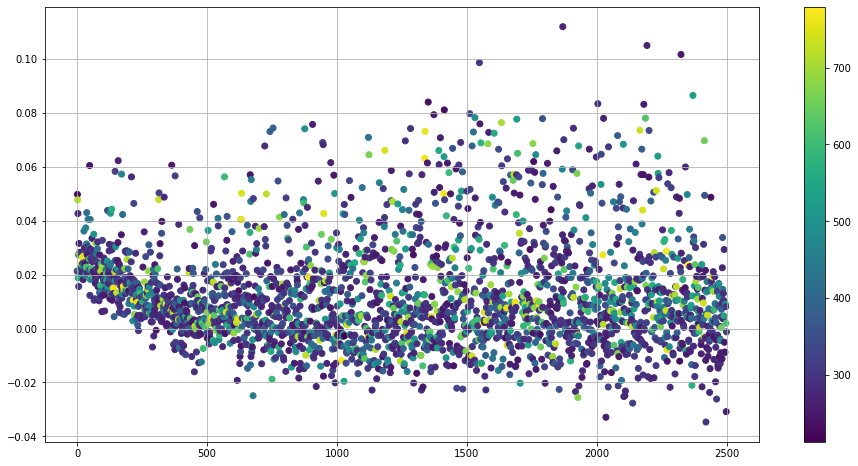

In [55]:
fig = plt.figure(figsize=(16, 8))
low = 4500
high = 7000
acting_degree = degrees_results[first_above, acting_p_results[first_above, :].astype(int)]
plt.scatter(np.arange(high-low), pd_results[first_above, low:high], c=acting_degree[low:high])
plt.grid()
plt.colorbar()
plt.show()

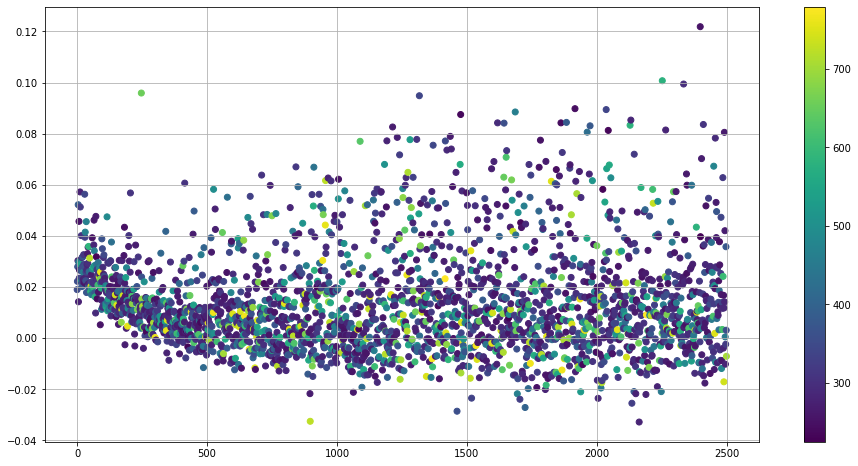

In [56]:
fig = plt.figure(figsize=(16, 8))
low = 4500
high = 7000
first_below = np.where(above_int==0)[0][0]
acting_degree = degrees_results[first_below, acting_p_results[first_below, :].astype(int)]
plt.scatter(np.arange(high-low), pd_results[first_below, low:high], c=acting_degree[low:high])
plt.grid()
plt.colorbar()
plt.show()

lijkt erop dat de correlatie die aan het begin tot stand komt (zodra als de eerste mensen L kiezen) stand houdt. of deze correlatie positief of negatief is hangt af van wie er op dat moment kiest. als de high-degree agents H kiezen krijg je de above average outcome (plot 1) en als de high-degree agents L kiezen dan krijg je de below average outcome (plot 2). 

#### Plot 1: veel runs van het model

In [10]:
n_results = np.zeros((runs, T+1))
pd_results = np.zeros((runs, T))
acting_p_results = np.zeros((runs, T))
degrees_results = np.zeros((runs, P))

for i in tqdm(range(runs)):
    n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
        = model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
    n_results[i,:] = n_evolution 
    pd_results[i,:] = pd 
    acting_p_results[i,:] = acting_p  
    degrees_results[i,:] = degrees

100%|██████████| 100/100 [24:19:34<00:00, 875.74s/it]     


In [13]:
# Save data
n_results_df = pd.DataFrame({i:n_results[i,:] for i in range(runs)})
n_results_df.to_csv('excel/n_results_df.csv')
pd_results_df = pd.DataFrame({i:pd_results[i,:] for i in range(runs)})
pd_results_df.to_csv('excel/pd_results_df.csv')
acting_p_results_df = pd.DataFrame({i:acting_p_results[i,:] for i in range(runs)})
acting_p_results_df.to_csv('excel/acting_p_results_df.csv')
degrees_results_df = pd.DataFrame({i:degrees_results[i,:] for i in range(runs)})
degrees_results_df.to_csv('excel/degrees_results_df.csv')

In [57]:
n_results_df = pd.read_csv('excel/n_results_df.csv')
n_results = n_results_df.to_numpy().T[1:,:]
pd_results_df = pd.read_csv('excel/pd_results_df.csv')
pd_results = pd_results_df.to_numpy().T[1:,:]
acting_p_results_df = pd.read_csv('excel/acting_p_results_df.csv')
acting_p_results = acting_p_results_df.to_numpy().T[1:,:]
degrees_results_df = pd.read_csv('excel/degrees_results_df.csv')
degrees_results = degrees_results_df.to_numpy().T[1:,:]

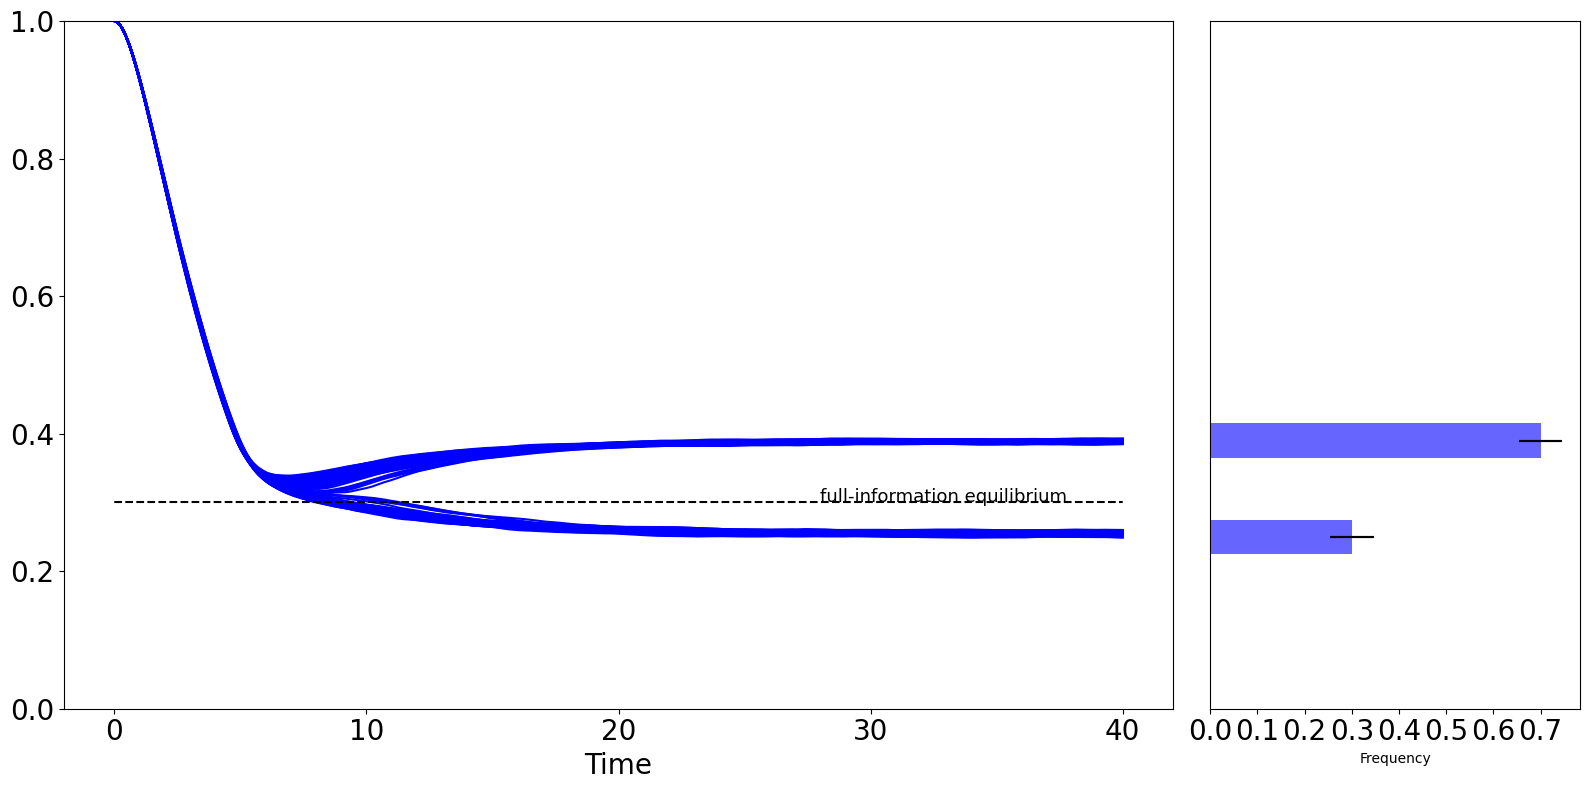

In [28]:
# set up plot
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[12, 4])
BREE1, BREE2 = br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)
x = np.arange(T+1)

# subplot with many simulations
plt.subplot(grid[0])
    # plotting
for i in range(runs):
    plt.plot(x, n_results[i,:], c='blue')
plt.plot(x, np.ones(T+1)*BREE1, c='black', linestyle='dashed')

    # pretty pretty
plt.annotate('full-information equilibrium', xy=(0.7*T, BREE1), xytext=(0.7*T, BREE1), fontsize=13)
plt.xticks(np.linspace(0,T,5), np.linspace(0,T/P,5, dtype=int), fontsize=20)
plt.yticks(fontsize=20)
#plt.grid()
plt.xlabel('Time', fontsize=20)
plt.ylim(0,1)

# bar subplot
plt.subplot(grid[1])
above = np.zeros(runs)
for i in range(runs):
    ave = np.mean(n_results[i,-100:])
    if ave > BREE1:
        above[i] = 1
plt.barh([0.25,0.39], [1-np.sum(above)/runs, np.sum(above)/runs], color='blue', height=0.05, alpha=0.6)
prob = np.sum(above)/runs
error = np.sqrt(((1-prob) * prob) / (runs-1))
plt.errorbar([1-prob, 1-prob], [0.25,0.25], xerr=error, color='black')
plt.errorbar([prob, prob], [0.39,0.39], xerr=error, color='black')
#plt.yticks([0.25, 0.4], ['Scarce', 'Abundant'], fontsize=20, rotation=45)
plt.yticks([])
plt.ylim(0,1)
plt.xticks(fontsize=20)
plt.xlabel('Frequency')
#plt.grid()

# save and show
plt.tight_layout()
plt.savefig(f'plots/paper/bistability.png', dpi=200)
plt.show()

#### Plot 2: majority illusion

/var/folders/1g/xdw6mj696n1_vgkt7srtq99m0000gn/T/ipykernel_707/443703372.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


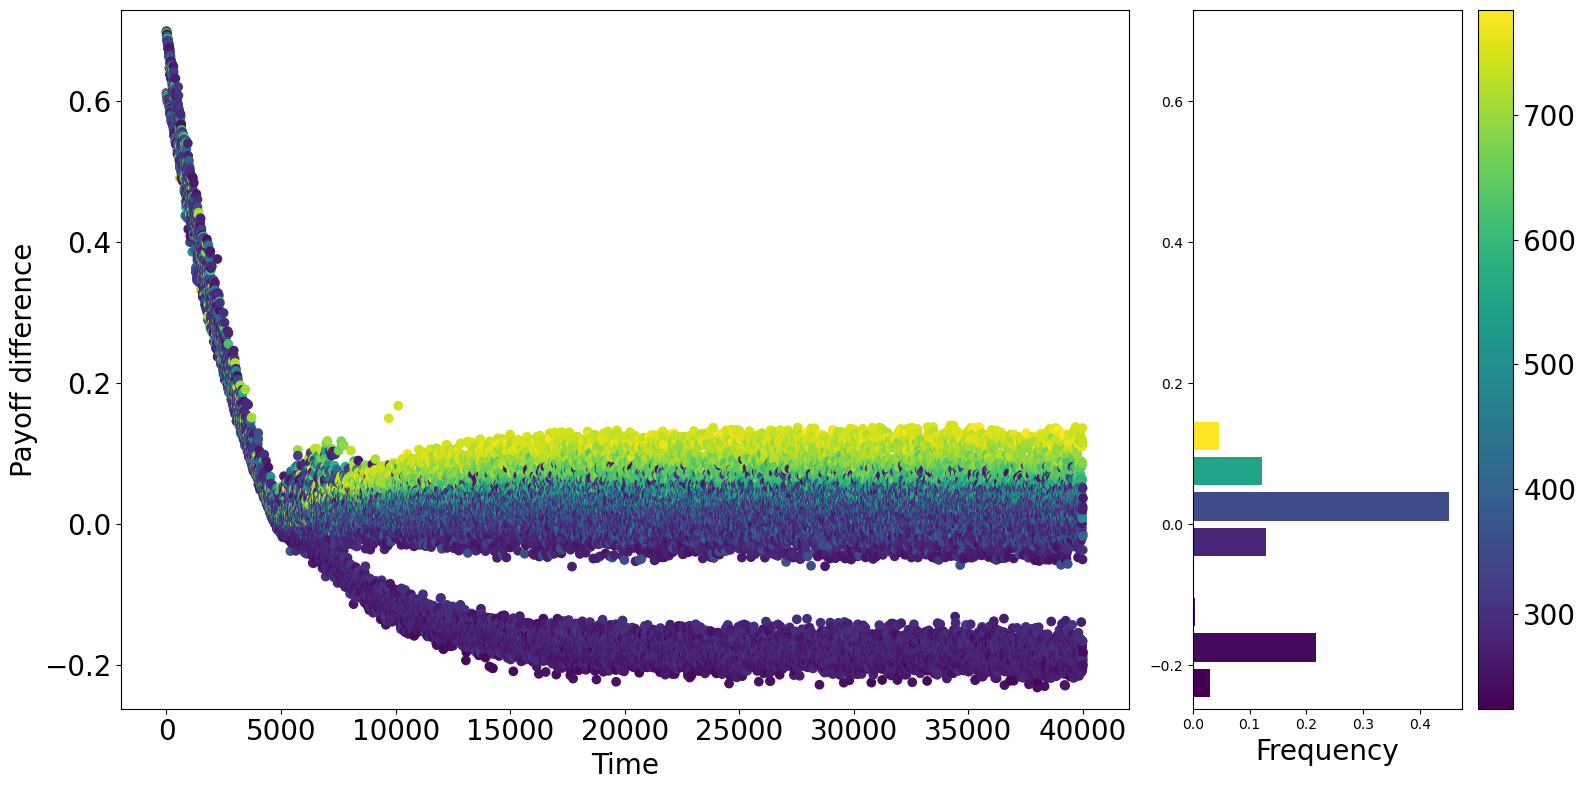

In [30]:
# above average
    # setup
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width ratios here
ax1 = plt.subplot(grid[0])  # Use the first part of the grid
ax2 = plt.subplot(grid[1])  # Use the second part of the grid

    # take above average results
above_int = above.astype(int)
above_indices = np.where(above_int == 1)[0]
first_above = above_indices[0]

    # subplot with payoff difference
acting_degree = degrees_results[first_above, acting_p_results[first_above, :].astype(int)]
scatter1 = ax1.scatter(np.arange(T), pd_results[first_above, :], c=acting_degree)  # Save the scatter object
#ax1.grid()
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Payoff difference', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylim(np.min(pd_results[first_above, :])-0.03, np.max(pd_results[0, :])+0.03)
cbar1 = plt.colorbar(scatter1, ax=ax2)  # Use the scatter object for colorbar
cbar1.ax.tick_params(labelsize=20)

    # calculate frequency per payoff difference and average degree for the second subplot
n_values = 10000
start = T - n_values
n_bins = np.ceil((np.max(pd_results[above_indices,-n_values:]) - np.min(pd_results[above_indices,-n_values:])) / 0.05).astype(int) +1
bin_cutoffs = np.linspace(np.min(pd_results[above_indices,-n_values:]), np.max(pd_results[above_indices,-n_values:]), n_bins)
bins = {i:[0, np.array([])] for i in range(n_bins-1)}
for id3, k in enumerate(np.where(above_int == 1)[0]):
    acting_degree = degrees_results[k, acting_p_results[k, :].astype(int)]
    for id1, i in enumerate(pd_results[k,-n_values:]):
        for id2, j in enumerate(bin_cutoffs):
            if i < j:
                bins[id2-1][0] += 1
                bins[id2-1][1] = np.append(bins[id2-1][1], acting_degree[start+id1])
                break
        # hier kan de id1 loop weg --> loop over de bin cutoffs en check met np.where waar de waarden van pd_results[k,-n_values:] daartussen zitten
        # kan dan de count pakken en de acting_degrees op die locaties pakken

    # colors of the bars
mean_values = [np.mean(i[1]) for i in bins.values()]
cmap = cm.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(mean_values), vmax=max(mean_values))
colors = [cmap(normalize(mean)) for mean in mean_values]

    # subplot of the frequencies
ax2.barh([np.mean([bin_cutoffs[i+1], bin_cutoffs[i]]) for i in range(n_bins-1)], [i[0]/(n_values*np.sum(above_int)) for i in bins.values()], height=bin_cutoffs[1] - bin_cutoffs[0] - 0.01, color=colors)
#ax2.grid()
ax2.set_ylim(np.min(pd_results[first_above, :])-0.03, np.max(pd_results[first_above, :])+0.03)
ax2.set_xlabel('Frequency', fontsize=20)

    # save and show
plt.tight_layout()
plt.savefig(f'plots/paper/above_equilibrium_scatter.png', dpi=200)
plt.show()

/var/folders/1g/xdw6mj696n1_vgkt7srtq99m0000gn/T/ipykernel_707/3692438484.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


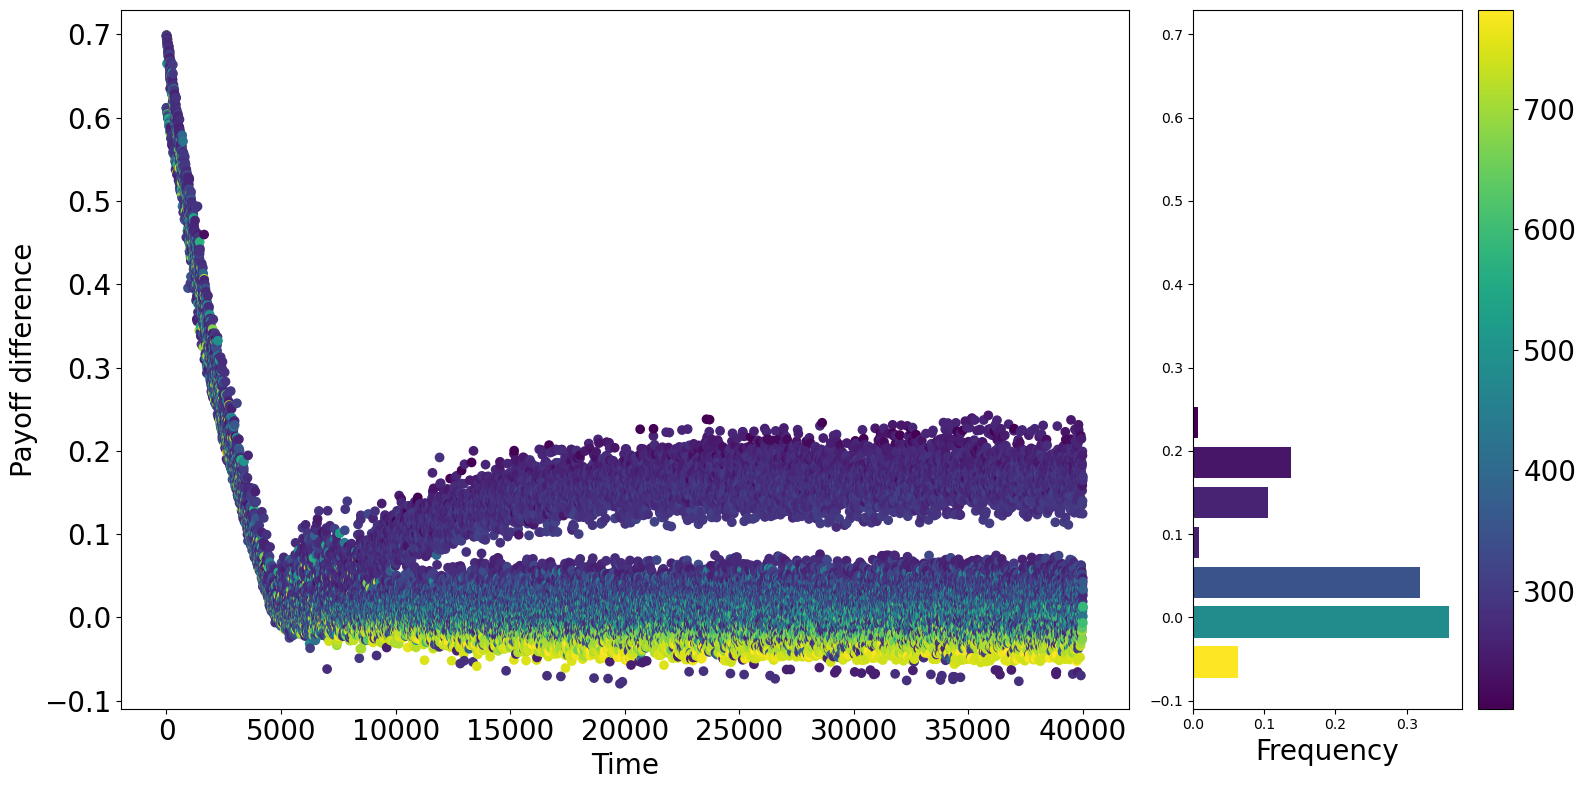

In [31]:
# below average
    # setup
fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width ratios here
ax1 = plt.subplot(grid[0])  # Use the first part of the grid
ax2 = plt.subplot(grid[1])  # Use the second part of the grid

    # take above average results
below_indices = np.where(above_int == 0)[0]
first_below = below_indices[0]

    # subplot with payoff difference
acting_degree = degrees_results[first_below, acting_p_results[first_below, :].astype(int)]
scatter1 = ax1.scatter(np.arange(T), pd_results[first_below, :], c=acting_degree)  # Save the scatter object
#ax1.grid()
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Payoff difference', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylim(np.min(pd_results[first_below, :])-0.03, np.max(pd_results[0, :])+0.03)
cbar1 = plt.colorbar(scatter1, ax=ax2)  # Use the scatter object for colorbar
cbar1.ax.tick_params(labelsize=20)

    # calculate frequency per payoff difference and average degree for the second subplot
n_values = 10000
start = T - n_values
n_bins = np.ceil((np.max(pd_results[below_indices,-n_values:]) - np.min(pd_results[below_indices,-n_values:])) / 0.05).astype(int) +1
bin_cutoffs = np.linspace(np.min(pd_results[below_indices,-n_values:]), np.max(pd_results[below_indices,-n_values:]), n_bins)
bins = {i:[0, np.array([])] for i in range(n_bins-1)}
for id3, k in enumerate(np.where(above_int == 0)[0]):
    acting_degree = degrees_results[k, acting_p_results[k, :].astype(int)]
    for id1, i in enumerate(pd_results[k,-n_values:]):
        for id2, j in enumerate(bin_cutoffs):
            if i < j:
                bins[id2-1][0] += 1
                bins[id2-1][1] = np.append(bins[id2-1][1], acting_degree[start+id1])
                break
        # hier kan de id1 loop weg --> loop over de bin cutoffs en check met np.where waar de waarden van pd_results[k,-n_values:] daartussen zitten
        # kan dan de count pakken en de acting_degrees op die locaties pakken

    # colors of the bars
mean_values = [np.mean(i[1]) for i in bins.values()]
cmap = cm.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(mean_values), vmax=max(mean_values))
colors = [cmap(normalize(mean)) for mean in mean_values]

    # subplot of the frequencies
ax2.barh([np.mean([bin_cutoffs[i+1], bin_cutoffs[i]]) for i in range(n_bins-1)], [i[0]/(n_values*np.sum(1-above_int)) for i in bins.values()], height=bin_cutoffs[1] - bin_cutoffs[0] - 0.01, color=colors)
#ax2.grid()
ax2.set_ylim(np.min(pd_results[first_below, :])-0.03, np.max(pd_results[first_below, :])+0.03)
ax2.set_xlabel('Frequency', fontsize=20)

    # save and show
plt.tight_layout()
plt.savefig(f'plots/paper/below_equilibrium_scatter.png', dpi=200)
plt.show()

#### Plot 3: effect network parameters

In [32]:
runs = 30
ne_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) 
ne_results = np.zeros((len(ne_array), runs))
skew_results = np.zeros((len(ne_array), runs))

for id1, i in tqdm(enumerate(ne_array)):
    for j in range(runs):    
        i2 = int(i*P)
        n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
            = model(n, z, P, i2, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, impact, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
        ave = np.mean(n_evolution[-100:])
        ne_results[id1, j] = ave 
        skew_results[id1, j] = skew

9it [30:01:30, 12010.06s/it]


#### old

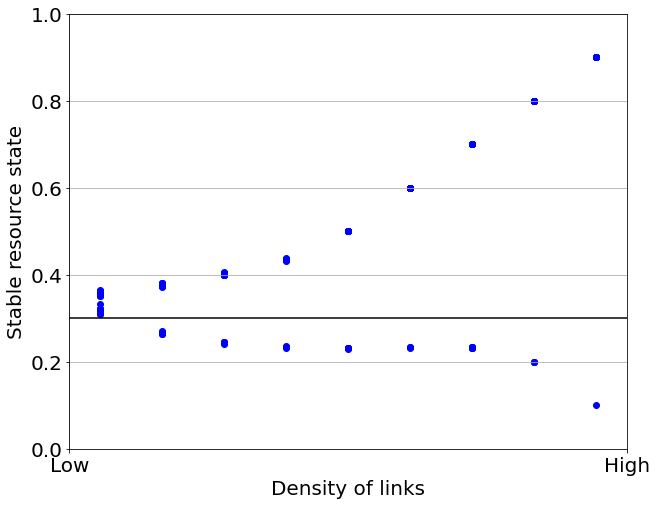

In [13]:
fig = plt.figure(figsize=(10, 8))
for i, x in enumerate(ne_array):
    plt.scatter(np.ones(runs)*i+0.5, ne_results[i,:], c='blue')
plt.plot(np.arange(len(ne_array)+1), np.ones(len(ne_array)+1) * br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)[0], c='black')
plt.grid()
plt.xlim(0,len(ne_array))
plt.ylim(0,1)
plt.xlabel('Density of links', fontsize=20)
plt.xticks([0, len(ne_array)], ['Low', 'High'], fontsize=20)
plt.ylabel('Stable resource state', fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f'plots/paper/network_dispersion.png', dpi=200)
plt.show()

#### new

In [33]:
# skew 250
skews = np.zeros(runs)
for i in range(runs):
    network, degrees = gen_net(P, ne)
    skew = calc_moment(degrees, P)
    skews[i] = skew
skew250 = np.mean(skews)
skew250 

1.494679636530064

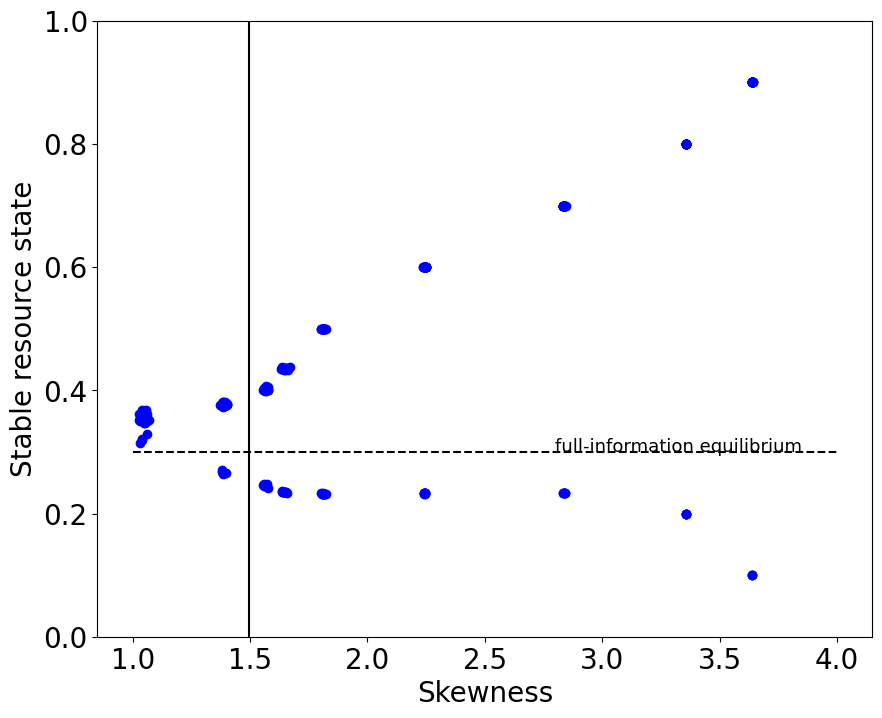

In [45]:
fig = plt.figure(figsize=(10, 8))
for i, x in enumerate(ne_array):
    plt.scatter(skew_results[i,:], ne_results[i,:], c='blue')
plt.plot([1,4], np.ones(2) * br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)[0], c='black', linestyle='dashed')
plt.annotate('full-information equilibrium', xy=(2.8, BREE1), xytext=(2.8, BREE1), fontsize=13)
plt.plot([skew250, skew250], [0, 1], c='black')
#plt.grid()
plt.ylim(0,1)
plt.xlabel('Skewness', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Stable resource state', fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(f'plots/paper/network_dispersion_v2.png', dpi=200)
plt.show()

#### Plot 4: Voor 1 network density het effect van environmental impact

In [36]:
impact_array = np.array([0, 1, 3, 5, 8]) 
impact_results = np.zeros(((len(impact_array)), runs))

for id1, i in tqdm(enumerate(impact_array)):
    for j in range(runs):    
        n_evolution, z_evolution, zl_predictions, pd, heuristic_fraction, observed_z, acting_p, degrees, skew \
            = model(n, z, P, ne, T, e1, d0, a1l, a1h, a2l, a2h, a3l, a3h, i, sigma, b1, b2, b3, h_upd_chance, eta, choice_intensity)
        ave = np.mean(n_evolution[-100:])
        impact_results[id1,j] = ave

0it [00:00, ?it/s]

5it [34:24:21, 24772.32s/it]


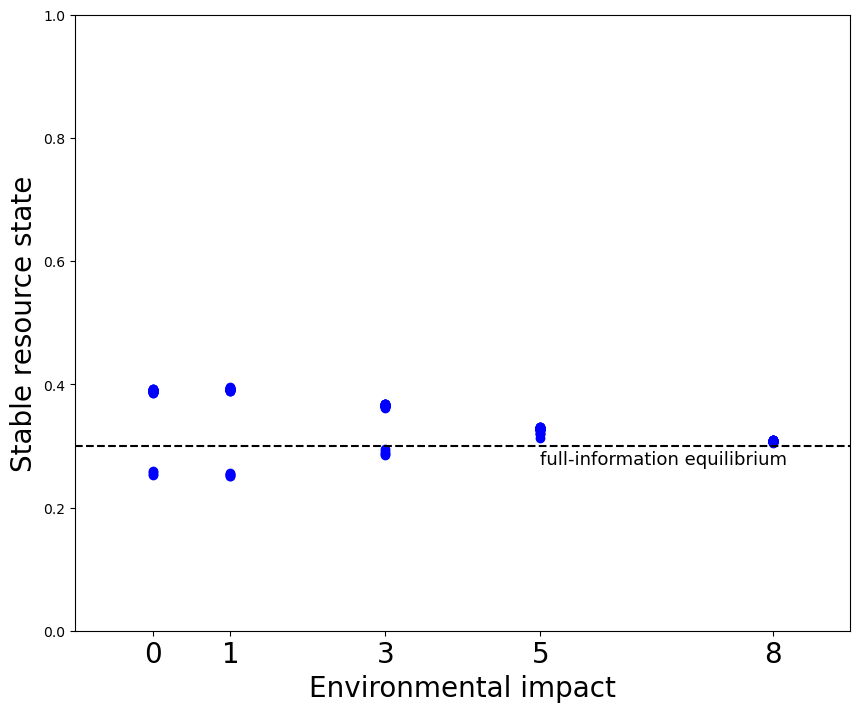

In [43]:
fig = plt.figure(figsize=(10, 8))
for id1, i in enumerate(impact_array):
    plt.scatter(np.ones(runs)*i, impact_results[id1,:], c='blue')
plt.plot(np.arange(start=-1, stop=np.max(impact_array)+2), np.ones(np.max(impact_array)+3) * br_longrun(d0, a1l, a1h, a2l, a2h, a3l, a3h, P)[0], c='black', linestyle='dashed')
plt.annotate('full-information equilibrium', xy=(5, BREE1-0.03), xytext=(5, BREE1-0.03), fontsize=13)
#plt.grid()
plt.xlabel('Environmental impact', fontsize=20)
plt.xticks(impact_array, impact_array, fontsize=20)
plt.ylabel('Stable resource state', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(-1,9)
plt.ylim(0,1)
plt.savefig(f'plots/paper/environmental_impact.png', dpi=200)
plt.show()